# Benchmarking MARS autoencoder

**Authorship:**
Adam Klie, *02/26/2022*
***
**Description:**
Notebook for benchmarking MARS on simulated data

<div class="alert alert-block alert-warning">
<b>TODOs</b>:
<ul>
    <b><li>Try this out on pancreatic islets using a set of reference datasets</li></b>
    <b><li></li></b>
    <b><li></li></b>
    <b><li></li></b>
    </ul>
</div>

## Set-up

In [24]:
# The classics
import sys
import pandas as pd
import numpy as np

# Others needed
import torch
import scanpy as sc

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [49]:
# Get the functions needed from the MARS codebase
sys.path.append("/cellar/users/aklie/opt/mars")
from model.experiment_dataset import ExperimentDataset
from model.mars import MARS
from args_parser import get_parser

In [4]:
# Check if cuda is available and set the device if it is
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load simulated data

In [93]:
# Counts with genes and cells
counts = pd.read_csv("simulated/truecounts.6.2000.200.1.tsv", sep="\t")
geneinfo = pd.read_csv("simulated/geneinfo.6.2000.200.1.tsv", sep="\t")
cellinfo = pd.read_csv("simulated/cellinfo.6.2000.200.1.tsv", sep="\t")

In [94]:
# Make an annData object
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 2000 × 200 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'

# Preprocess

In [95]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.scale(adata, max_value=10, zero_center=True)

In [96]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')
sc.pp.pca(adata, n_comps=50)
sc.tl.tsne(adata)

... storing 'Batch' as categorical
... storing 'Group' as categorical


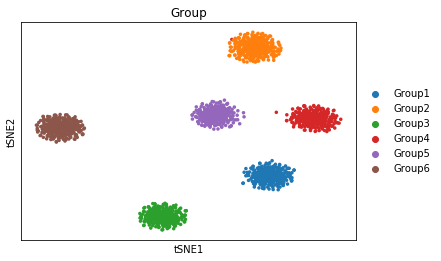

In [97]:
sc.pl.tsne(adata, color=['Group'],size=50)

# Train MARS Unannotated Dataset with No New Cell-types

## Prep data

In [98]:
# Split into traininig and test set
from sklearn.model_selection import train_test_split
adata.obs["NumGroup"] = [int(group[-1]) for group in adata.obs["Group"]]
train_cells, test_cells = train_test_split(adata.obs_names, random_state=42, shuffle=True)

In [101]:
# Make the train ExperimentDataset
train_adata = adata[train_cells, :]
train_y = np.array(train_adata.obs['NumGroup'], dtype=np.int64)
annotated = ExperimentDataset(train_adata.X.toarray(), train_adata.obs_names, train_adata.var_names, "train", train_y)

== Dataset: Found 1500 items 
== Dataset: Found 6 classes


In [102]:
# Make the test ExperimentDataset
test_adata = adata[test_cells, :]
test_y = np.array(test_adata.obs['NumGroup'], dtype=np.int64)
unannotated = ExperimentDataset(test_adata.X.toarray(), test_adata.obs_names, test_adata.var_names, "test", test_y)

== Dataset: Found 500 items 
== Dataset: Found 6 classes


In [103]:
# Make the pretrain ExperimentDataset which in this case is just the unlabeled data
pretrain_data = ExperimentDataset(train_adata.X.toarray(), train_adata.obs_names, train_adata.var_names, "train", train_y)
n_clusters = len(np.unique(unannotated.y))

== Dataset: Found 1500 items 
== Dataset: Found 6 classes


## Train model

In [104]:
# Set-up the parameters for training and instantiate the model
params, unknown = get_parser().parse_known_args()
params.cuda = True
params.device = device
mars = MARS(n_clusters, params, [annotated], unannotated, pretrain_data, hid_dim_1=1000, hid_dim_2=100)

In [114]:
# Train MARS and predict on unlabeled cells
adata_mars, landmarks, scores = mars.train(evaluation_mode=True, save_all_embeddings=True) # evaluation mode

Pretraining..

=== Epoch: 30 ===
Train acc: 1.0


In [199]:
landmarks[0].shape, landmarks[1].shape

(torch.Size([5, 100]), torch.Size([6, 100]))

In [194]:
scores

{'recall': 0.9931773879142299,
 'adj_mi': 0.943439029364968,
 'nmi': 0.9519401755556327,
 'adj_rand': 0.9478146595944511,
 'precision': 0.9723127805339002,
 'accuracy': 0.9815059445178336,
 'f1_score': 0.982024659312135}

## Visualization of embedding and labeling
Visualize the results

In [124]:
sc.pp.neighbors(adata_mars, n_neighbors=30, use_rep="MARS_embedding")
sc.tl.umap(adata_mars)

/cellar/users/aklie/opt/miniconda3/envs/mars/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 6 separate connected components using meta-embedding (experimental)
  n_components


... storing 'MARS_labels' as categorical


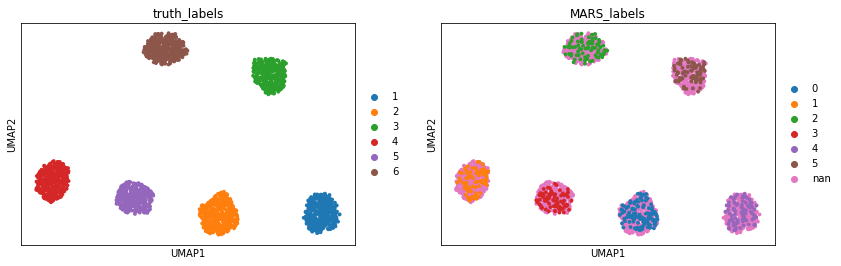

In [125]:
sc.pl.umap(adata_mars, color=["truth_labels", "MARS_labels"])

# Train MARS Unannotated Dataset with Single New Cell-type

## Prep data

In [170]:
# Holdout group 6
group6_cells = adata.obs_names[adata.obs["NumGroup"] == 6]
other_cells = adata.obs_names[adata.obs["NumGroup"] != 6]

In [171]:
# Split into traininig and test set
train_cells, test_cells = train_test_split(other_cells, random_state=42, shuffle=True)
test_cells = test_cells.append(group6_cells)

In [172]:
# Make the train ExperimentDataset
train_adata = adata[train_cells, :]
train_y = np.array(train_adata.obs['NumGroup'], dtype=np.int64)
annotated = ExperimentDataset(train_adata.X.toarray(), train_adata.obs_names, train_adata.var_names, "train", train_y)

== Dataset: Found 1243 items 
== Dataset: Found 5 classes


In [181]:
# Make the test ExperimentDataset
test_adata = adata[test_cells, :]
test_y = np.array(test_adata.obs['NumGroup'], dtype=np.int64)
unannotated = ExperimentDataset(test_adata.X.toarray(), test_adata.obs_names, test_adata.var_names, "test", test_y)
n_clusters = len(np.unique(unannotated.y))

== Dataset: Found 757 items 
== Dataset: Found 6 classes


## Train model

In [182]:
# Set-up the parameters for training and instantiate the model
params, unknown = get_parser().parse_known_args()
params.cuda = True
params.device = device
mars = MARS(n_clusters, params, [annotated], unannotated, hid_dim_1=1000, hid_dim_2=100)

In [190]:
# Train MARS and predict on unlabeled cells
adata_mars, landmarks, scores = mars.train(evaluation_mode=True, save_all_embeddings=False) # evaluation mode

Pretraining..

=== Epoch: 30 ===
Train acc: 1.0


In [191]:
scores

{'recall': 0.9931773879142299,
 'adj_mi': 0.943439029364968,
 'nmi': 0.9519401755556327,
 'adj_rand': 0.9478146595944511,
 'precision': 0.9723127805339002,
 'accuracy': 0.9815059445178336,
 'f1_score': 0.982024659312135}

## Visualization of embedding and labeling

In [192]:
sc.pp.neighbors(adata_mars, n_neighbors=30, use_rep="MARS_embedding")
sc.tl.umap(adata_mars)

/cellar/users/aklie/opt/miniconda3/envs/mars/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


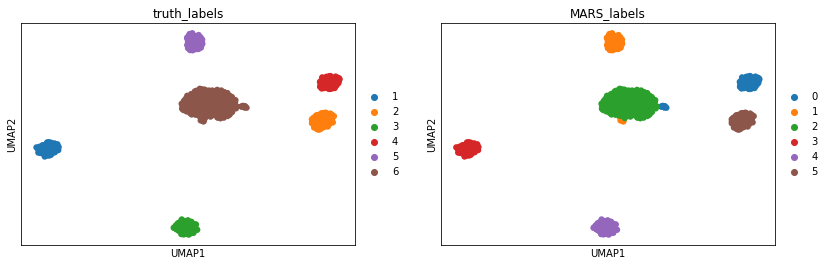

In [193]:
sc.pl.umap(adata_mars, color=["truth_labels", "MARS_labels"])

# References

1. [MARS Paper](https://www.nature.com/articles/s41592-020-00979-3)
2. [Stanford MARS website](http://snap.stanford.edu/mars/)
3. [MARS Github](https://github.com/snap-stanford/mars)